# Convolutional Neural Networks

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.io import read_image

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU detected, using CPU")

cpu_device = torch.device("cpu")

GPU detected: NVIDIA T400 4GB


## Load Image

In [3]:
def show_image(images, labels):
    fix, axs = plt.subplots(ncols=len(images), squeeze=False, figsize=(12, 6))
    for i, (image, label) in enumerate(zip(images, labels)):
        img = transforms.ToPILImage()(image.to('cpu'))
        axs[0, i].imshow(np.asarray(img), cmap='gray')
        axs[0, i].set_title(label)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
image_transforms = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),
    transforms.Grayscale()
])

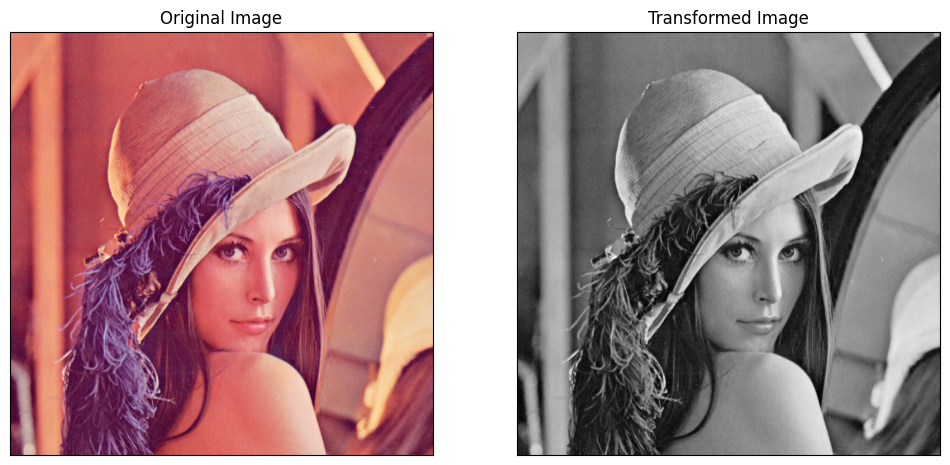

In [5]:
origin_img = read_image('../assets/images/lena_std.png')
trans_img = image_transforms(origin_img)
show_image([origin_img, trans_img], ['Original Image', 'Transformed Image'])

## Convolutions for Edge Detection

### Sobel Edge Detector

In [6]:
class SobelEdgeDetection(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_x = nn.Conv2d(1, 1, padding=1, kernel_size=3, bias=False)
        self.conv_y = nn.Conv2d(1, 1, padding=1, kernel_size=3, bias=False)

    def forward(self, x):
        g_x = torch.abs(self.conv_x(x))
        g_y = torch.abs(self.conv_y(x))
        return g_x+g_y

edge_detector = SobelEdgeDetection()
print(edge_detector)
print(edge_detector.conv_x.weight.shape)

SobelEdgeDetection(
  (conv_x): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv_y): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
torch.Size([1, 1, 3, 3])


In [7]:
sobel_x = torch.tensor([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]],
    dtype=torch.float32).unsqueeze(0).unsqueeze(0)
sobel_y = torch.tensor([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]],
    dtype=torch.float32).unsqueeze(0).unsqueeze(0)

edge_detector.conv_x.weight.data = sobel_x
edge_detector.conv_x.weight.requires_grad = False
edge_detector.conv_y.weight.data = sobel_y
edge_detector.conv_y.weight.requires_grad = False

In [8]:
filter_image = edge_detector(trans_img)

print(filter_image.shape)

torch.Size([1, 512, 512])


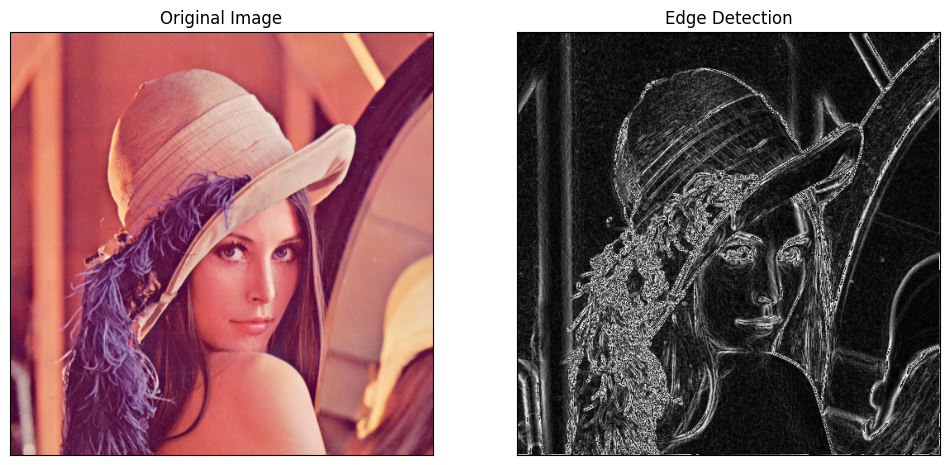

In [9]:
show_image([origin_img, filter_image], ['Original Image', 'Edge Detection'])

## Learning a Kernel

In [10]:
trans_img = trans_img.to(device)
filter_image = filter_image.to(device)
print(filter_image.device)

cuda:0


In [11]:
learning_rate = 0.1
num_epochs = 10000

model = SobelEdgeDetection()
model.train()
model.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for _ in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    y_pred = model(trans_img)

    loss = loss_fn(y_pred, filter_image)
    loss.backward()
    optimizer.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

### Show Result

pred soble x:  Parameter containing:
tensor([[[[ 1.1462,  0.1491, -1.2434],
          [ 1.6486, -0.1111, -1.5995],
          [ 1.2673, -0.0375, -1.2200]]]], device='cuda:0', requires_grad=True)
pred soble y:  Parameter containing:
tensor([[[[-1.0150, -1.7579, -1.2586],
          [-0.2201,  0.1327,  0.1079],
          [ 1.2795,  1.5870,  1.1443]]]], device='cuda:0', requires_grad=True)


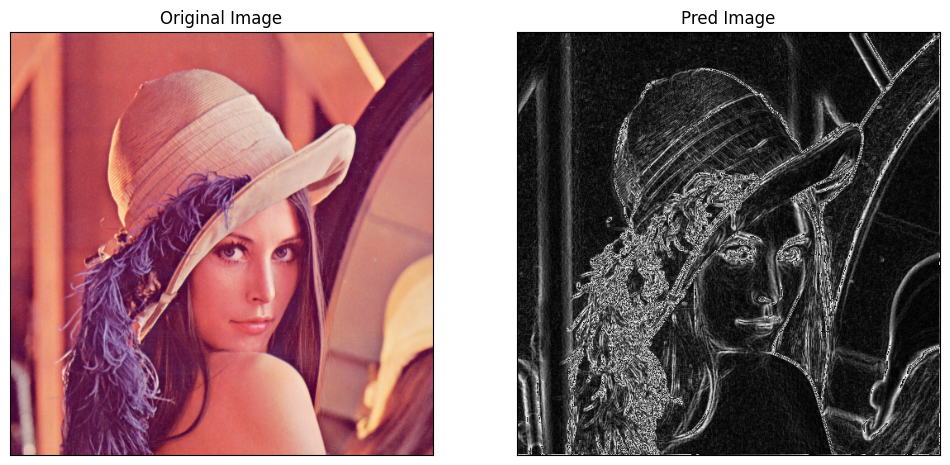

In [12]:
show_image([origin_img, y_pred], ['Original Image', 'Pred Image'])
print('pred soble x: ', model.conv_x.weight)
print('pred soble y: ', model.conv_y.weight)

### Error analysis

In [13]:
!pip install scikit-image

In [14]:
pred_image = y_pred.detach().cpu().numpy()
true_image = filter_image.detach().cpu().numpy()
print(pred_image.shape)

(1, 512, 512)


In [15]:
from skimage.metrics import structural_similarity as ssim

# Compute the Mean Squared Error (MSE)
mse = np.mean((pred_image - true_image) ** 2)
print(f'Mean Squared Error (MSE): {mse:.4f}')

# Compute the Structural Similarity Index Measure (SSIM)
ssim_value = ssim(pred_image, true_image, multichannel=True, channel_axis=0, data_range=1)
print(f'Structural Similarity Index Measure (SSIM): {ssim_value}')

Mean Squared Error (MSE): 0.0003
Structural Similarity Index Measure (SSIM): 0.9888059496879578


## References

- [ A guide to convolution arithmetic for deep learning ](https://github.com/vdumoulin/conv_arithmetic)
- [ Sobel Edge Detector ](https://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm)